## Miniproject 2: MovieLens Visualization



### Download data

In [1]:
import requests

url_dict = {
     'data.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/data.csv',
     'movies.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/movies.csv',
     'train.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/train.csv',
     'test.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/test.csv'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('data.csv')
download_file('movies.csv')
download_file('train.csv')
download_file('test.csv')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import numpy.linalg as la
from surprise import Reader, SVD, Dataset, accuracy

np.random.seed(36)

In [2]:
data = pd.read_csv('data.csv')
movies = pd.read_csv('movies.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Init Data

Do pandas wizardry to select certain movies and ratings.

In [3]:
movie_names = movies.iloc[:, 1]

# 10 received the most rating
most_pd = data["Movie ID"].value_counts()[:10]
# most_pd.index - 1 gives the index
most_data = data.loc[data["Movie ID"].isin(most_pd.keys())]

# 10 with highest rating
high_pd = data.groupby('Movie ID')['Rating'].mean().sort_values(ascending = False)[:10]
high_data = data.loc[data["Movie ID"].isin(high_pd.keys())]

# 10 random movies, indicies
rand_indices = np.random.randint(0, len(movies), size = (10))

# 3 genres
horror_pd = movies.loc[movies["Horror"] == 1]
crime_pd = movies.loc[movies["Crime"] == 1]
western_pd = movies.loc[movies["Western"] == 1]

horror_data = data.loc[data["Movie ID"].isin(horror_pd["Movie ID"])]
crime_data = data.loc[data["Movie ID"].isin(crime_pd["Movie ID"])]
western_data = data.loc[data["Movie ID"].isin(western_pd["Movie ID"])]

Create histograms

In [6]:
# helper function for hist_subplot
# a single hist plot
def rating_hist(ax, data, title, xlabel = True, ylabel = True, dirs = None):
    
    # ax passed in from hist_subplot
    # xlabel & ylabel decides whether to put labels. We want just some subplots have labels
    # dirs = None means not to save plot
    
    ax.hist(data["Rating"], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], color = "goldenrod", ec = "white")
    if xlabel:
        ax.set_xlabel("Rating", fontsize = 10)
    if ylabel:
        ax.set_ylabel("Frequency")
    ax.set_title(title, loc = "right", fontsize = 10)
    ax.set_title(f"Mean: {round(np.mean(data['Rating']), 3)}", loc = "left", fontsize = 10)
    

def hist_subplot(data, most_data, high_data, genre1, genre2, genre3):
    # dirs is where to store subplot, if not None
    
    fig, axs = plt.subplots(2, 3)
    fig.set_size_inches(12, 8)
    
    # first row: all, most, high
    rating_hist(axs[0, 0], data, "All movies", xlabel = False, ylabel = True)
    rating_hist(axs[0, 1], most_data, "10 most rated", xlabel = False, ylabel = False)
    rating_hist(axs[0, 2], high_data, "10 highest rated", xlabel = False, ylabel = False)
    
    # second row: genre 1~3
    rating_hist(axs[1, 0], genre1, "Horror movies", xlabel = True, ylabel = False)
    rating_hist(axs[1, 1], genre2, "Crime movies", xlabel = False, ylabel = False)
    rating_hist(axs[1, 2], genre3, "Western movies", xlabel = False, ylabel = False)
    
    return fig

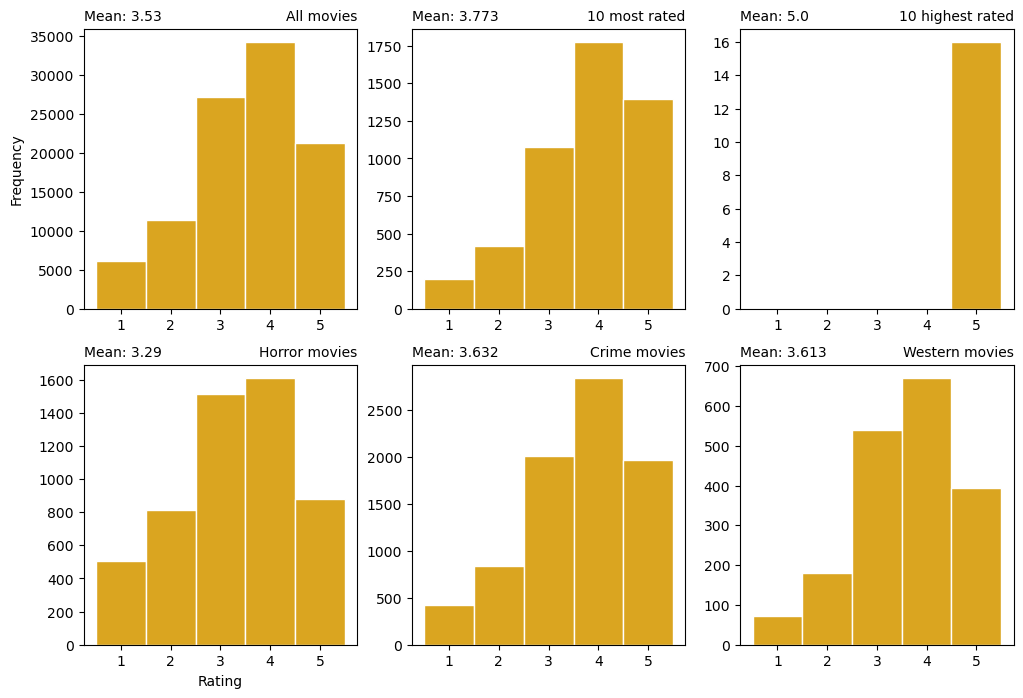

In [8]:
fig = hist_subplot(data, most_data, high_data, horror_data, crime_data, western_data)
plt.savefig("2x3hist.png")

## SVD from homework 5

In [9]:
def grad_U(Ui, Yij, Vj, reg, eta):
    return eta * (reg * Ui - Vj * (Yij - np.matmul(Vj, Ui)))

def grad_V(Vj, Yij, Ui, reg, eta):
    return eta * (reg * Vj - Ui * (Yij - np.matmul(Vj, Ui)))

def get_err(U, V, Y, reg=0.0):
    errors = []
    for i, j, Y_ij in Y:
        errors.append(0.5 * (Y_ij - np.matmul(V[j-1], U[i-1]))**2)
    return np.mean(errors)


def train_model(M, N, K, Y, eta, reg, eps = 0.0001, max_epochs = 300):
    # Initialize entries of U and V and losses
    U = np.random.uniform(-0.5, 0.5, (M, K))
    V = np.random.uniform(-0.5, 0.5, (N, K))
    loss_vals = [get_err(U, V, Y)]

    for iter in range(max_epochs):
        # Shuffle matrix
        Y = Y[np.random.permutation(len(Y))]
        for datum in Y:
            U[datum[0] - 1] -= grad_U(U[datum[0] - 1], datum[2], V[datum[1] - 1], reg, eta)
            V[datum[1] - 1] -= grad_V(V[datum[1] - 1], datum[2], U[datum[0] - 1], reg, eta)
        loss_vals.append(get_err(U, V, Y))
        if iter > 0 and (loss_vals[iter] - loss_vals[iter + 1]) / (loss_vals[0] - loss_vals[1]) <= eps:
            break
    return U, V, get_err(U, V, Y)

Train models

In [10]:
Y_train = np.array(train).astype(int)
Y_test = np.array(test).astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

eta = 0.03  # learning rate
reg = 0.1   # regularization
eps = 0.001 # early stopping
max_epochs = 100

E_in = []
E_out = []

# Use to compute Ein and Eout
U, V, err = train_model(M, N, K, Y_train, eta, reg, eps, max_epochs)
E_in = err
E_out = get_err(U, V, Y_test)
print(f"E_in: {E_in}")
print(f"E_out: {E_out}")

Factorizing with  943  users,  1682  movies.
E_in: 0.3293964545263
E_out: 0.4529382375227012


Find A and project

In [11]:
A = np.linalg.svd(V.transpose())[0]
Vt2 = np.dot(A[:,:2].transpose(), V.transpose())
Ut2 = np.dot(A[:,:2].transpose(), U.transpose())

for i in range(len(Vt2)):
    Vt2[i] -= np.mean(Vt2[i])
    Vt2[i] /= np.std(Vt2[i])
    Ut2[i] -= np.mean(Ut2[i])
    Ut2[i] /= np.std(Ut2[i])

### SVD plots

In [12]:
# a single projection plot
def proj_plot(Vt, indicies, title, dirs, plot_size = (8, 8), fontsize = 10):
    # dirs = None means not to save plot
    coords = Vt[:, indicies]
    labels = movie_names[indicies]
    
    fig, ax = plt.subplots()
    fig.set_size_inches(plot_size)
    ax.scatter(coords[0], coords[1])
    ax.set_title(title)
    for idx, label in enumerate(labels):
        ax.annotate(label, (coords[0, idx], coords[1, idx]), fontsize = fontsize)
    if dirs != None:
        plt.savefig(dirs, dpi = 600, bbox_inches = "tight")
    return fig

In [13]:
# helper function for proj_subplot
# a single projection plot
def proj_helper(ax, Vt, indicies, title):
    
    # dirs = None means not to save plot
    coords = Vt[:, indicies]
    labels = movie_names[indicies]
    
    fig.set_size_inches(8, 8)
    ax.scatter(coords[0], coords[1])
    ax.set_title(title)
    for idx, label in enumerate(labels):
        ax.annotate(label, (coords[0, idx], coords[1, idx]), fontsize = 10)



# 3 x 2 projection subplots
def proj_subplot(Vt, rand_indices, most_indices, high_indices, genre1_indices, genre2_indices, genre3_indices, genre_names):
    
    # genre_names is a list [name1, name2, name3]
    
    fig, axs = plt.subplots(3, 2)
    fig.set_size_inches(8, 12)
    
    # first row: all, most
    proj_helper(axs[0, 0], Vt, rand_indices, "10 Random Movies")
    proj_helper(axs[0, 1], Vt, most_indices, "10 Most Rated")
    
    # second row: high, genre1
    proj_helper(axs[1, 0], Vt, high_indices, "10 Highest Rated")
    proj_helper(axs[1, 1], Vt, genre1_indices, genre_names[0])
    
    # third row: genre2 & 3
    proj_helper(axs[2, 0], Vt, genre2_indices, genre_names[1])
    proj_helper(axs[2, 1], Vt, genre3_indices, genre_names[2])
    
    return fig

In [14]:
# subplot is too crowed, don't use it

dont_use_subplot = "Don't"
if dont_use_subplot != "Don't":
    genre_names = ["Horror", "Crime", "Western"]
    proj_SVD = proj_subplot(Vt2, rand_indices, most_indices, high_indices, horror_pd.index, crime_pd.index, western_pd.index, genre_names)

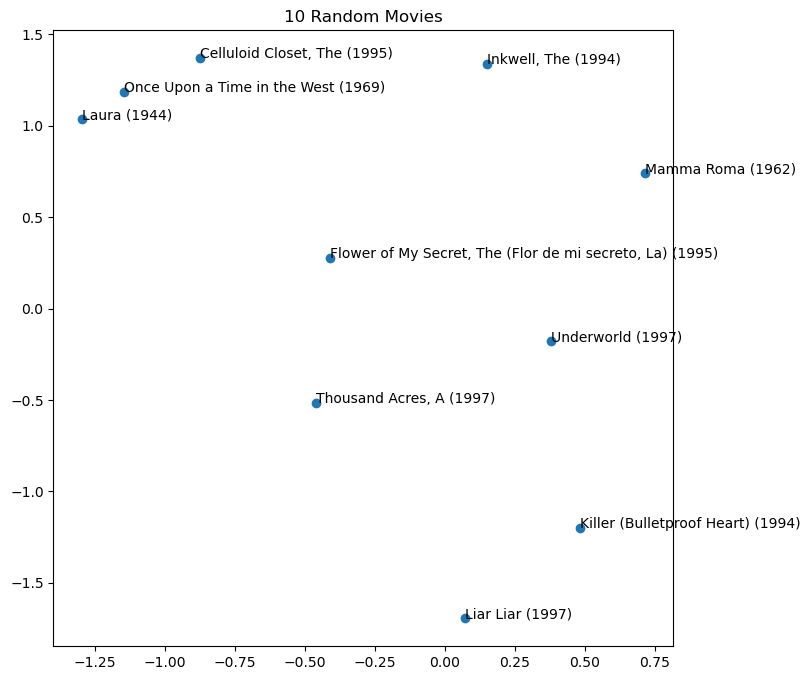

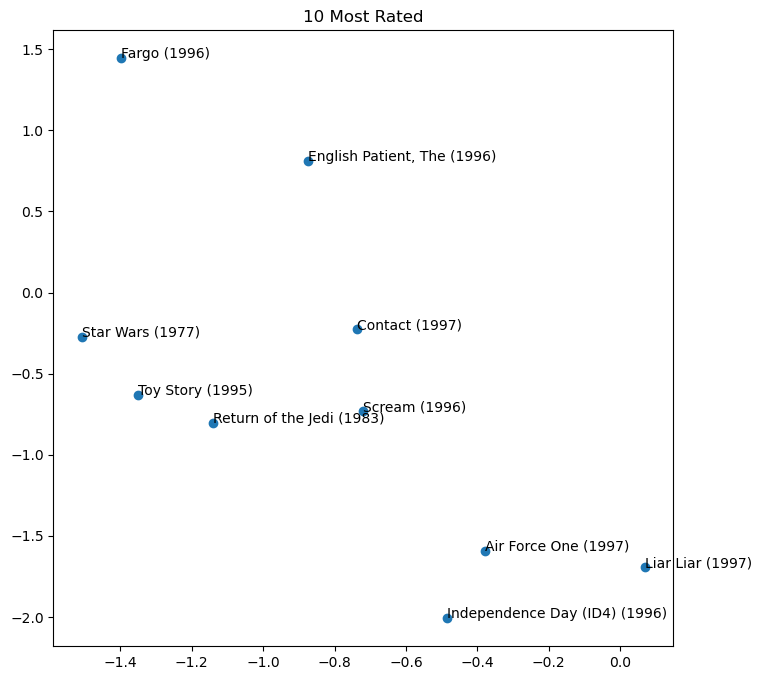

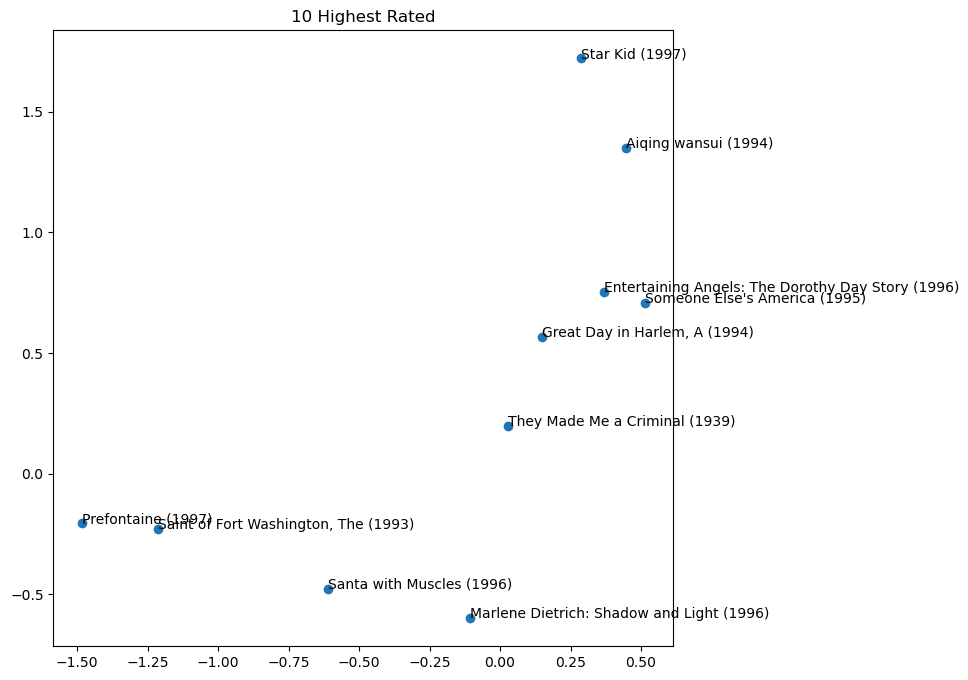

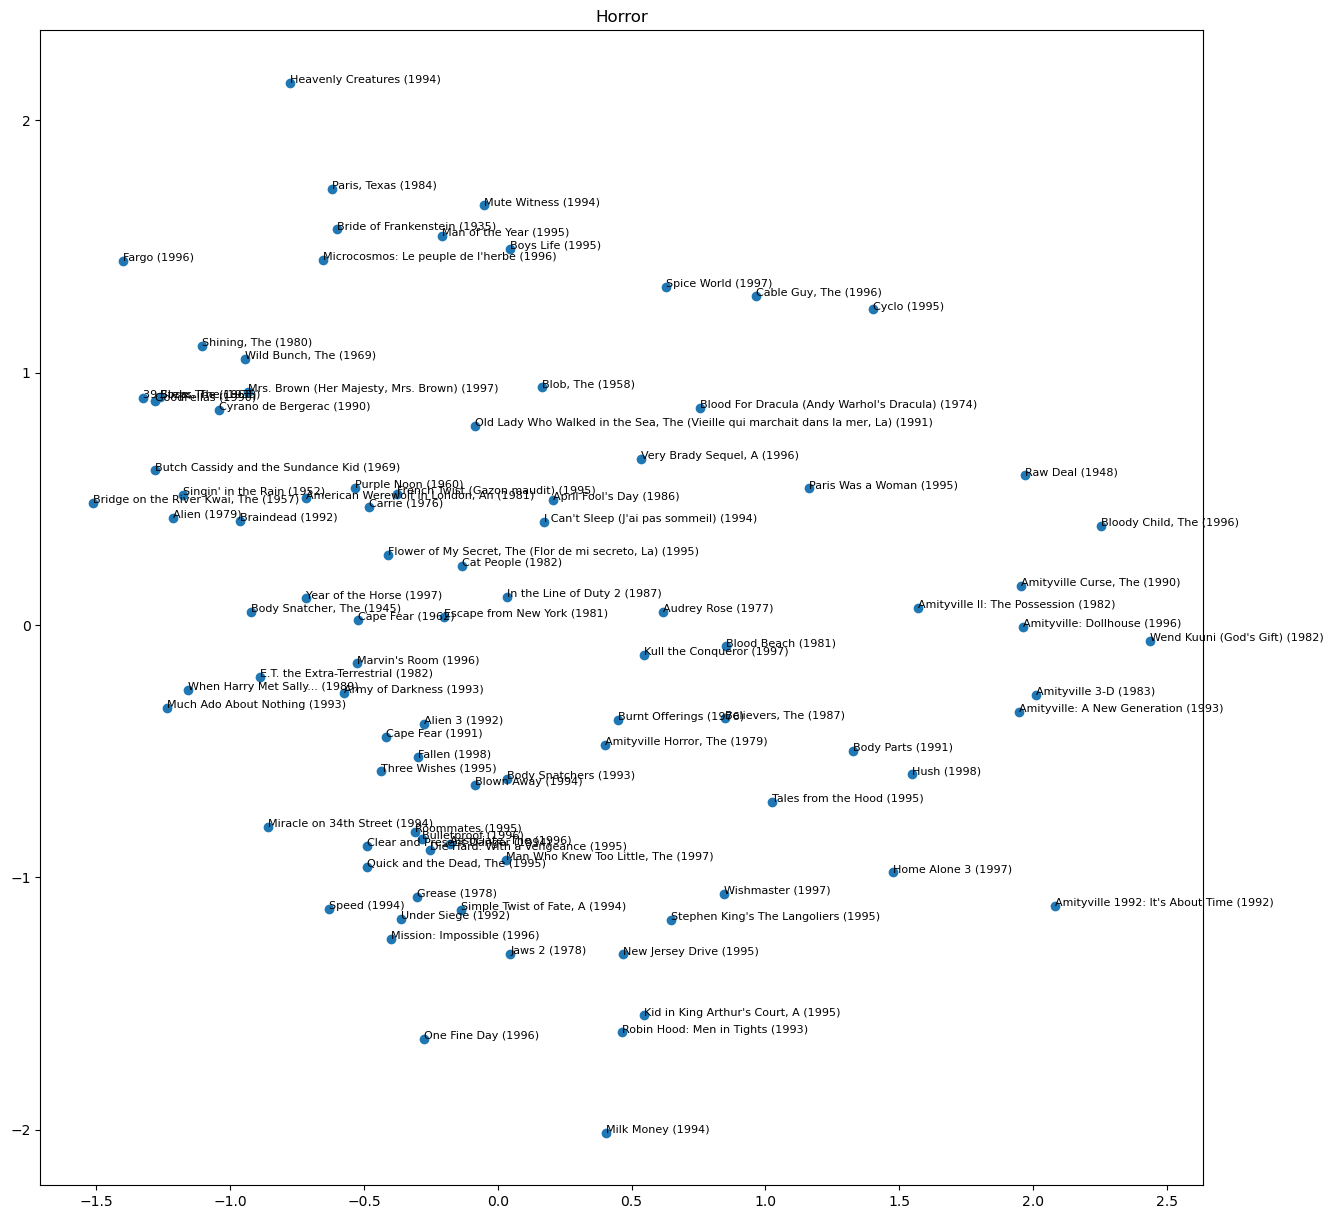

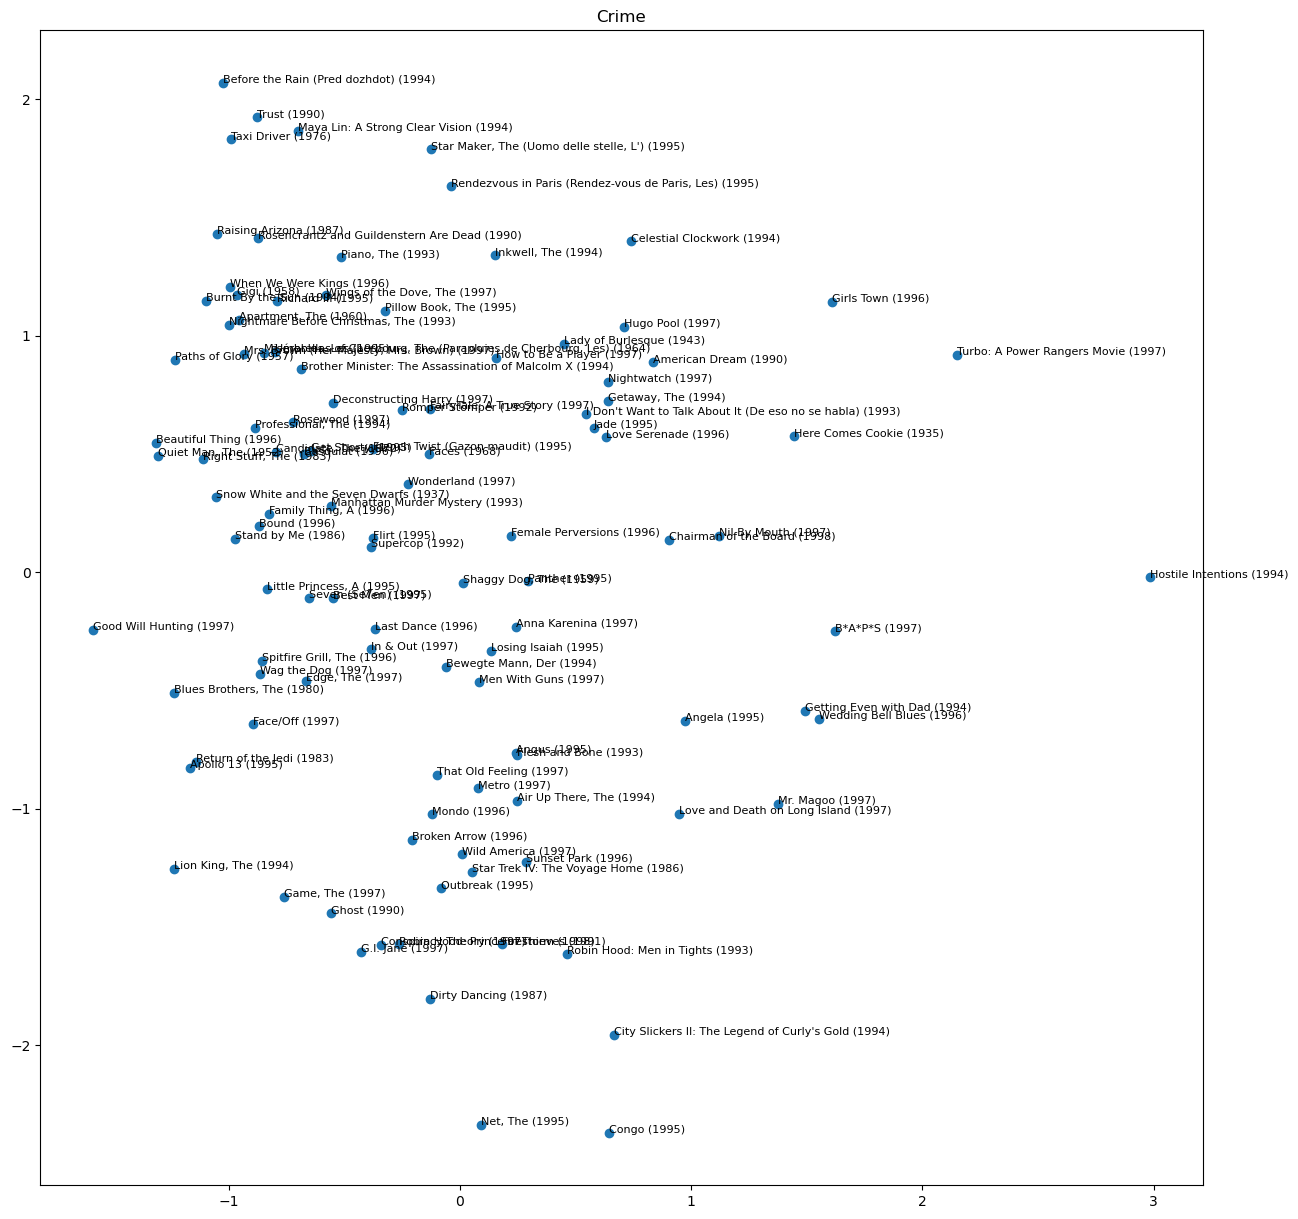

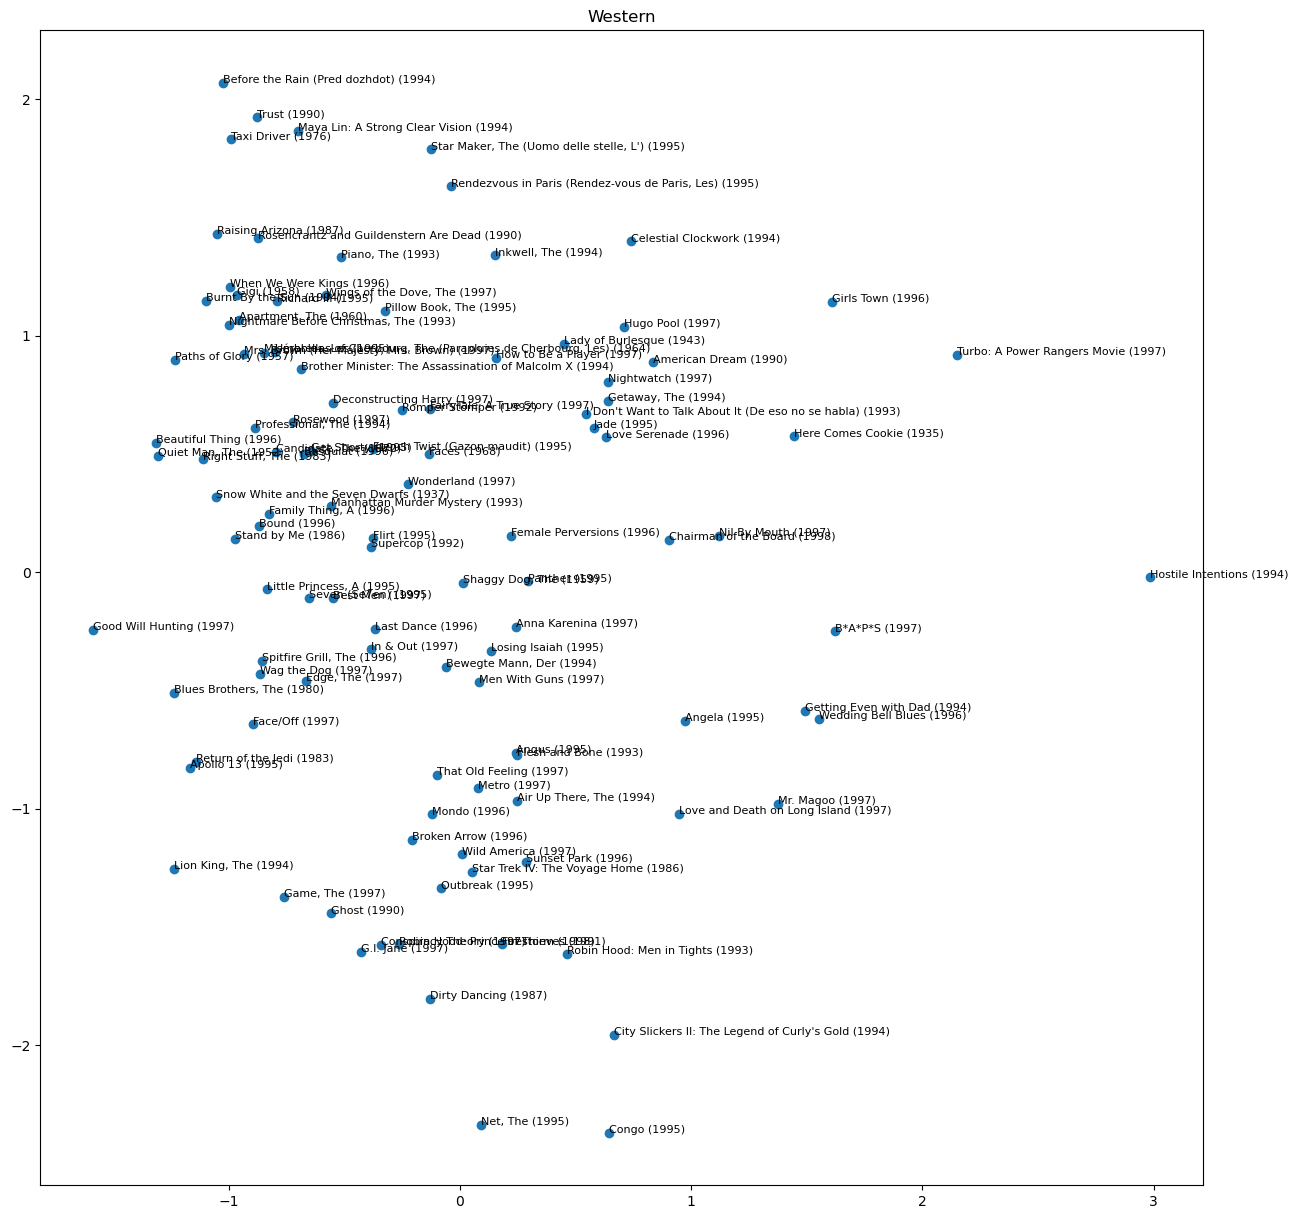

In [17]:
# random 10 movies
fig_rand = proj_plot(Vt2, rand_indices, "10 Random Movies", "rand10_biased.png")

# top10 high rating
fig_top = proj_plot(Vt2, most_pd.index - 1, "10 Most Rated", "pop10_biased.png")

# top10, received most ratings
fig_most = proj_plot(Vt2, high_pd.index - 1, "10 Highest Rated", "most10_biased.png")

# Horror
fig_horror = proj_plot(Vt2, horror_pd.index - 1, "Horror", "horror_SVD.png", plot_size = (15, 15), fontsize = 8)

# Crime
fig_crime = proj_plot(Vt2, crime_pd.index - 1, "Crime", "crime_SVD.png", plot_size = (15, 15), fontsize = 8)

# Western
fig_crime = proj_plot(Vt2, crime_pd.index - 1, "Western", "western_SVD.png", plot_size = (15, 15), fontsize = 8)

## Biased SVD

In [18]:
def grad_U_bias(Ui, Yij, Vj, ai, bj, reg, eta):
    return eta * (reg * Ui - Vj * (Yij - np.matmul(Vj, Ui) - ai - bj))

def grad_V_bias(Vj, Yij, Ui, ai, bj, reg, eta):
    return eta * (reg * Vj - Ui * (Yij - np.matmul(Vj, Ui) - ai - bj))

def grad_bias(Vj, Yij, Ui, ai, bj, eta):
    return -1 * eta * (Yij - np.dot(Ui, Vj) - ai - bj)

def get_err_bias(U, V, Y, a, b, reg=0.0):
    errors = []
    for i, j, Y_ij in Y:
        errors.append(0.5 * (Y_ij - np.matmul(V[j-1], U[i-1]) - a[i - 1] - b[j - 1])**2)
    return np.mean(errors)


def train_model_bias(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    # Initialize entries of U and V and losses
    U = np.random.uniform(-0.5, 0.5, (M, K))
    V = np.random.uniform(-0.5, 0.5, (N, K))
    a = np.random.uniform(-0.5, 0.5, (M, ))
    b = np.random.uniform(-0.5, 0.5, (N, ))
    loss_vals = [get_err(U, V, Y)]

    for iter in range(max_epochs):
        # Shuffle matrix
        Y = Y[np.random.permutation(len(Y))]
        for datum in Y:
            U[datum[0] - 1] -= grad_U_bias(U[datum[0] - 1], datum[2], V[datum[1] - 1], a[datum[0] - 1], b[datum[1] - 1], reg, eta)
            V[datum[1] - 1] -= grad_V_bias(V[datum[1] - 1], datum[2], U[datum[0] - 1], a[datum[0] - 1], b[datum[1] - 1], reg, eta)
            bias_grad = grad_bias(U[datum[0] - 1], datum[2], V[datum[1] - 1], a[datum[0] - 1], b[datum[1] - 1], eta)
            a[datum[0] - 1] -= bias_grad
            b[datum[1] - 1] -= bias_grad
        loss_vals.append(get_err(U, V, Y))
        if iter > 0 and (loss_vals[iter] - loss_vals[iter + 1]) / (loss_vals[0] - loss_vals[1]) <= eps:
            break
    return U, V, a, b, get_err(U, V, Y)

In [19]:
Y_train = np.array(train).astype(int)
Y_test = np.array(test).astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

eta = 0.03  # learning rate
reg = 0.1   # regularization
eps = 0.001 # early stopping
max_epochs = 100

E_in = []
E_out = []

# Use to compute Ein and Eout
U_biased, V_biased, err = train_model(M, N, K, Y_train, eta, reg, eps, max_epochs)
E_in = err
E_out = get_err(U, V, Y_test)
print(f"E_in: {E_in}")
print(f"E_out: {E_out}")

Factorizing with  943  users,  1682  movies.
E_in: 0.3358790577412715
E_out: 0.4529382375227012


In [20]:
A_biased = np.linalg.svd(V_biased.transpose())[0]
Vt2_biased = np.dot(A_biased[:,:2].transpose(), V_biased.transpose())
Ut2_biased = np.dot(A_biased[:,:2].transpose(), U_biased.transpose())

for i in range(len(Vt2_biased)):
    Vt2_biased[i] -= np.mean(Vt2_biased[i])
    Vt2_biased[i] /= np.std(Vt2_biased[i])
    Ut2_biased[i] -= np.mean(Ut2_biased[i])
    Ut2_biased[i] /= np.std(Ut2_biased[i])

### Biased SVD plots

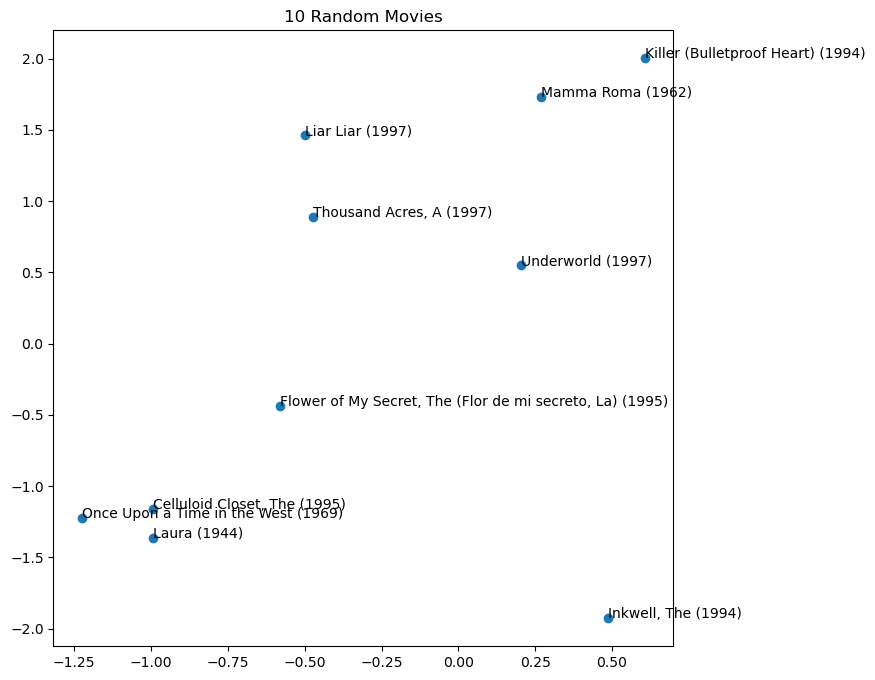

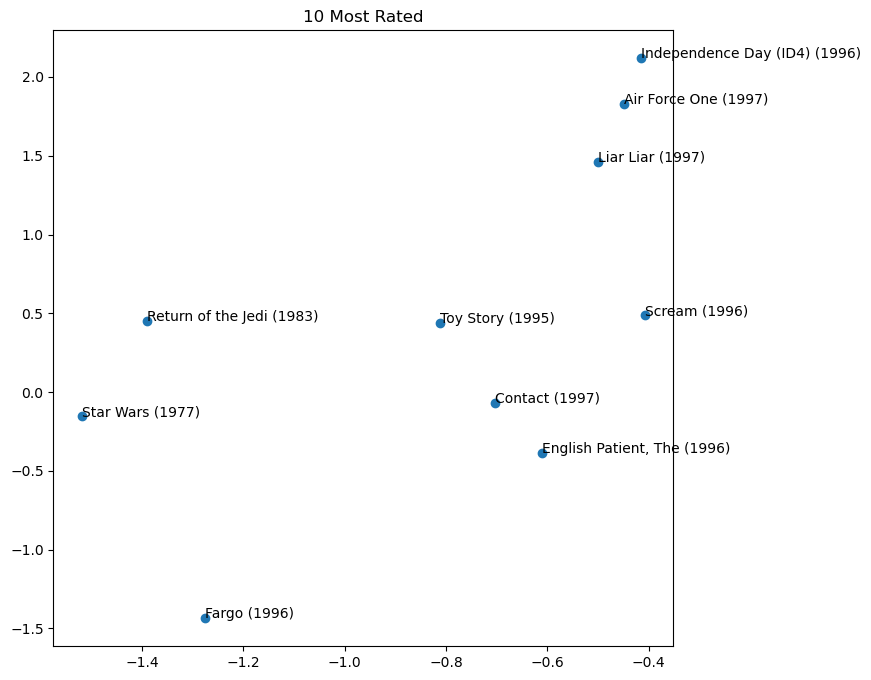

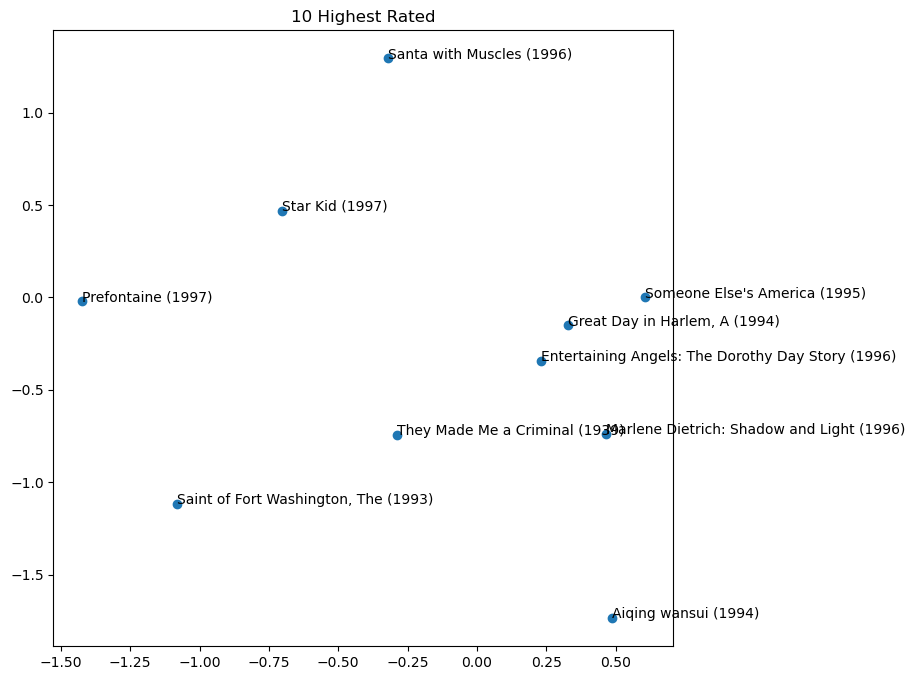

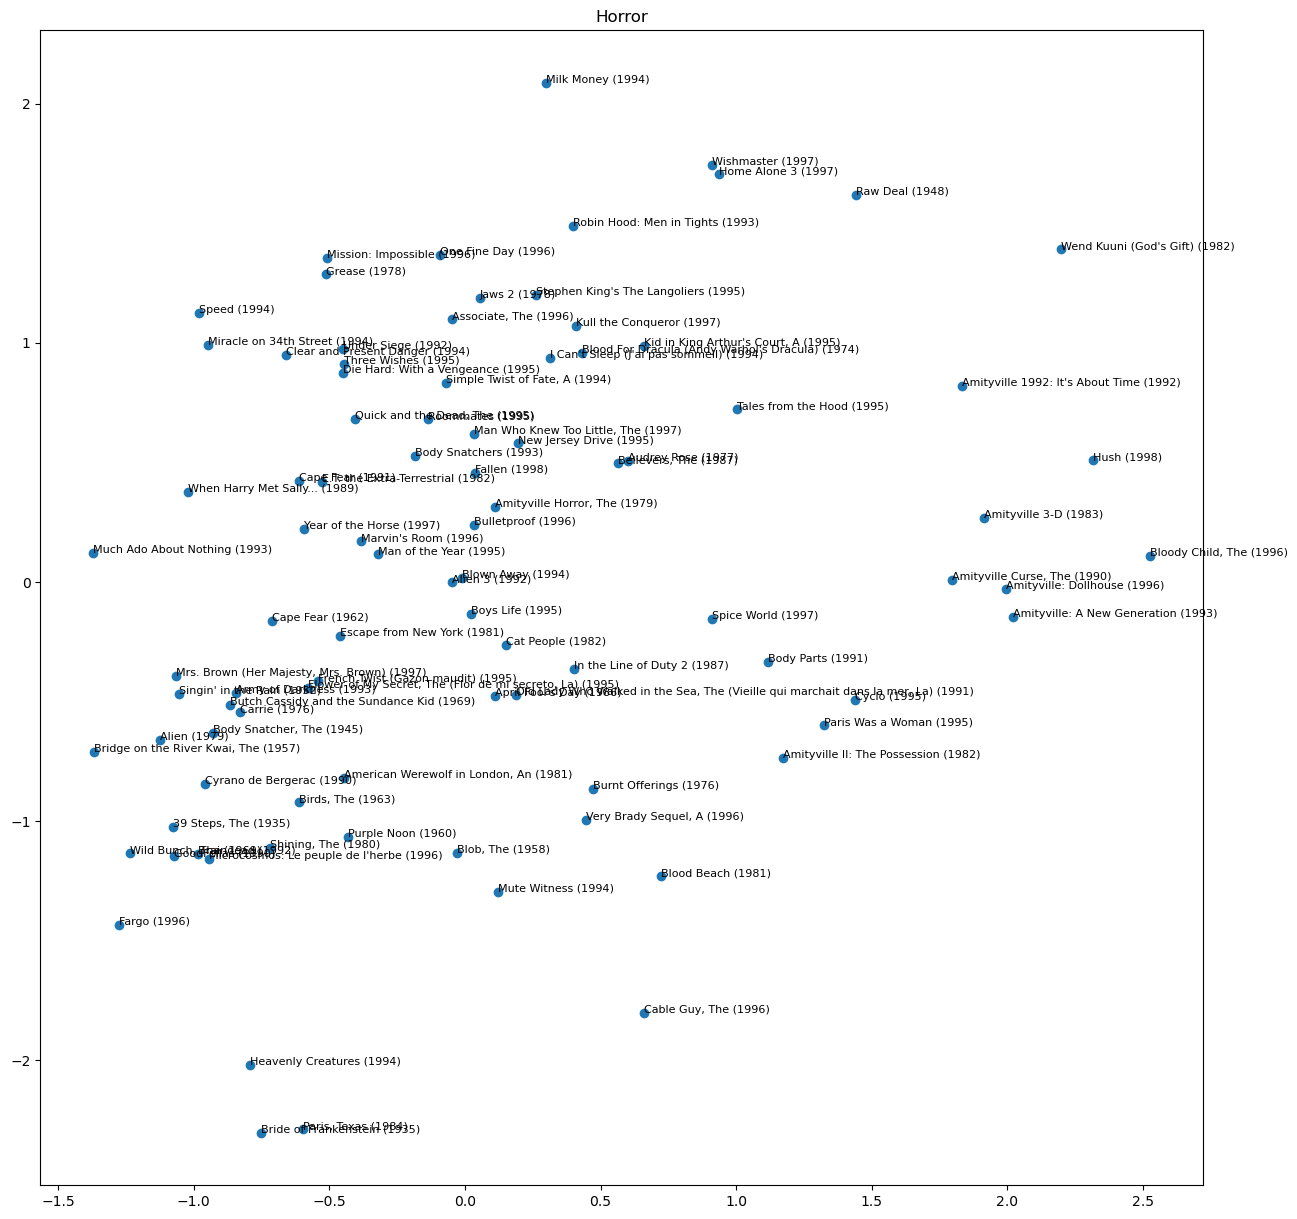

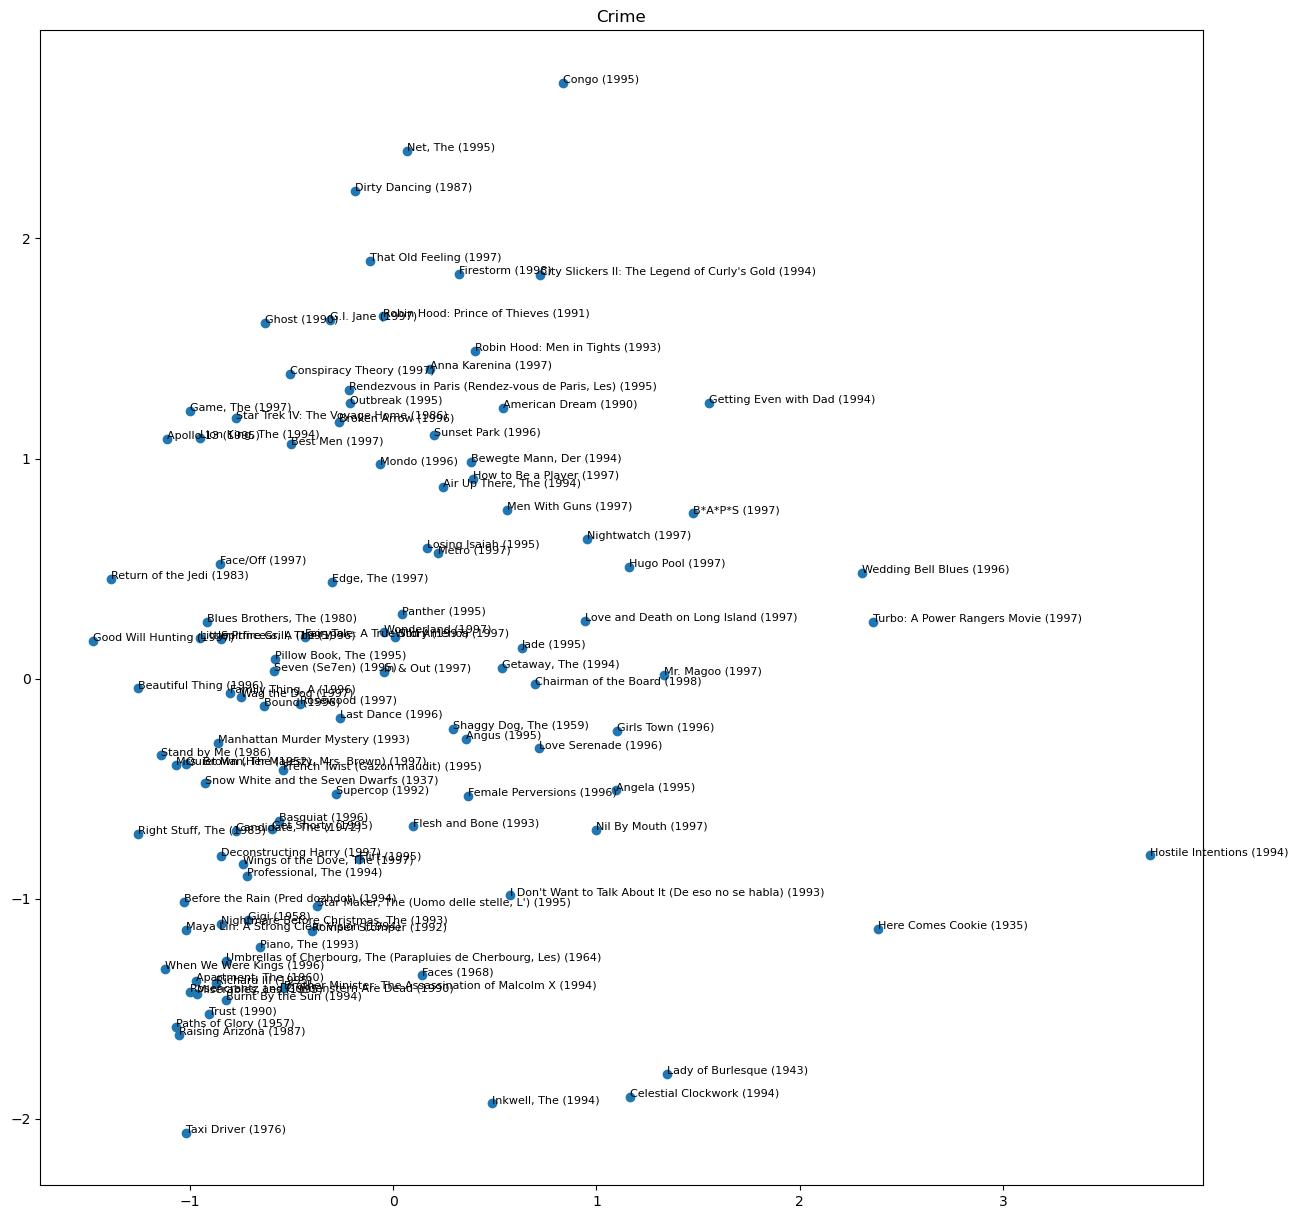

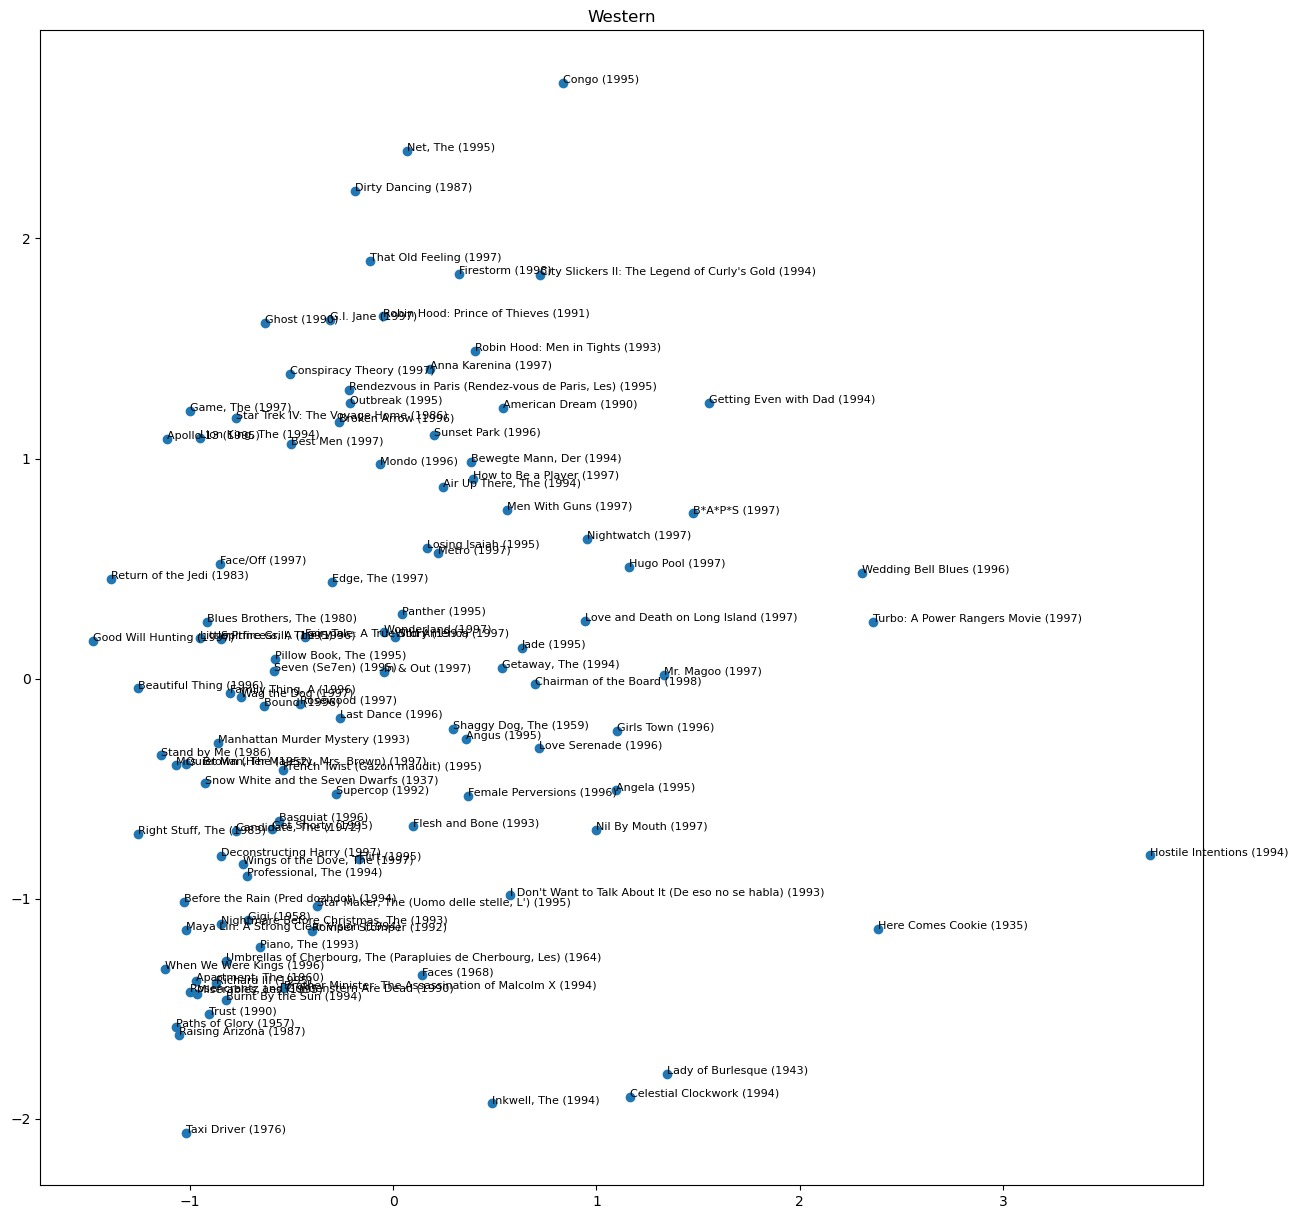

In [22]:
# random 10 movies
fig_rand = proj_plot(Vt2_biased, rand_indices, "10 Random Movies", "rand10_biased.png")

# top10 high rating
fig_top = proj_plot(Vt2_biased, most_pd.index - 1, "10 Most Rated", "pop10_biased.png")

# top10, received most ratings
fig_most = proj_plot(Vt2_biased, high_pd.index - 1, "10 Highest Rated", "most10_biased.png")

# Horror
fig_horror = proj_plot(Vt2_biased, horror_pd.index - 1, "Horror", "horror_SVD_biased.png", plot_size = (15, 15), fontsize = 8)

# Crime
fig_crime = proj_plot(Vt2_biased, crime_pd.index - 1, "Crime", "crime_SVD_biased.png", plot_size = (15, 15), fontsize = 8)

# Western
fig_crime = proj_plot(Vt2_biased, crime_pd.index - 1, "Western", "western_SVD_biased.png", plot_size = (15, 15), fontsize = 8)

## Off the Shelf: Surprise

Model training

In [23]:
# Initialize supriselib objects
reader = Reader(rating_scale=(1, 5))
sp_train = Dataset.load_from_df(df=train, reader=reader)
sp_test = Dataset.load_from_df(df=test, reader=reader)

sp_train = sp_train.build_full_trainset()
sp_test = sp_test.build_full_trainset()
sp_trainset = sp_train.build_testset()
sp_testset = sp_test.build_testset()

# Initialize SVD and fit
k_factors = 20
algo = SVD(n_factors = k_factors, n_epochs = 20, biased = True, lr_all = 0.005, reg_all = 0, init_mean = 0, init_std_dev = 0.01)
algo.fit(sp_train)

U = algo.pu
Vt = algo.qi.T

# Test fit
print(f'train: {accuracy.rmse(algo.test(sp_trainset), verbose = False)}')
print(f'test: {accuracy.rmse(algo.test(sp_testset), verbose = False)}')

train: 0.912670098157363
test: 0.9368924231897173


### Surprise plots

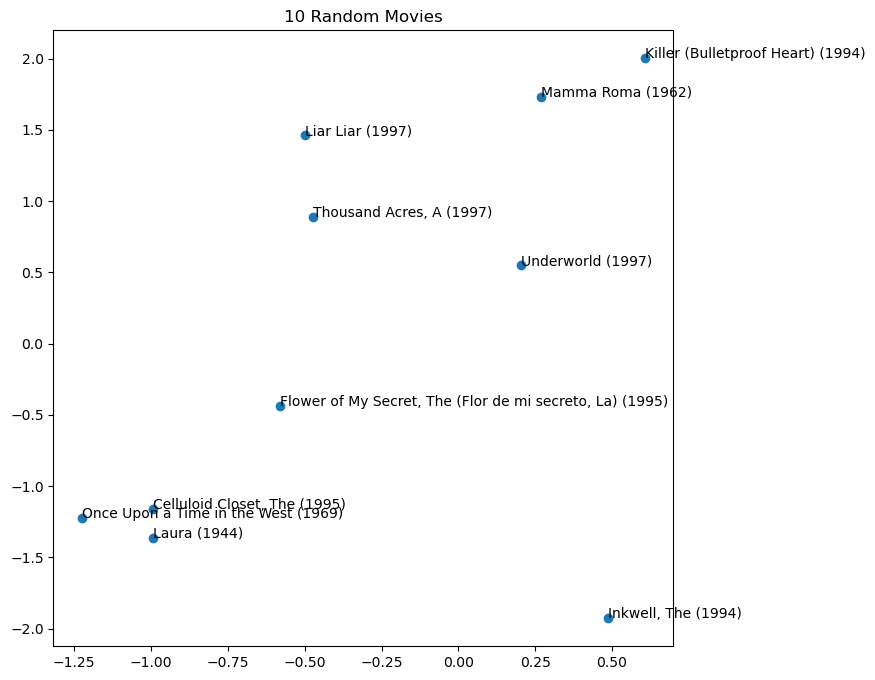

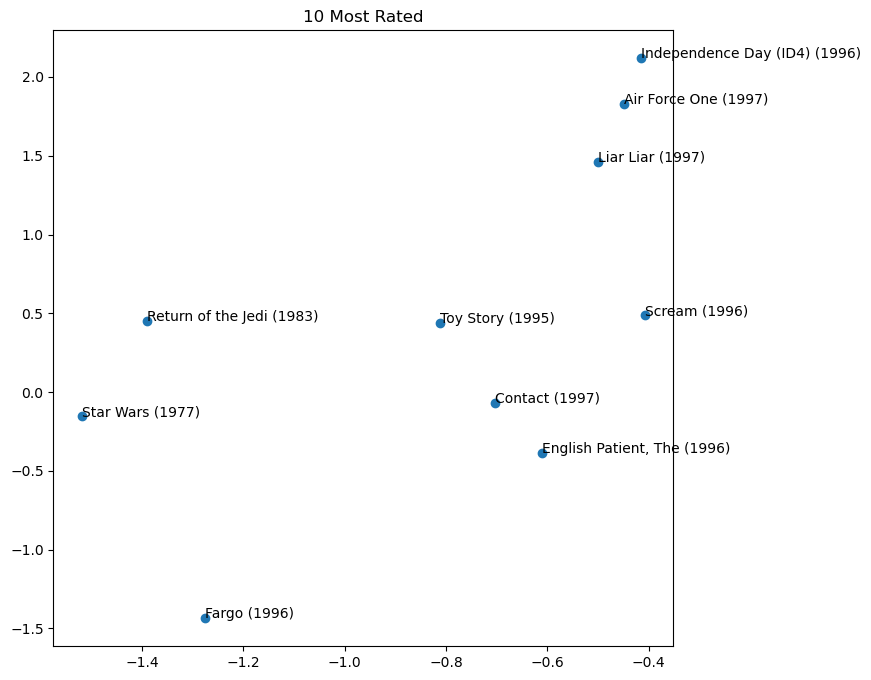

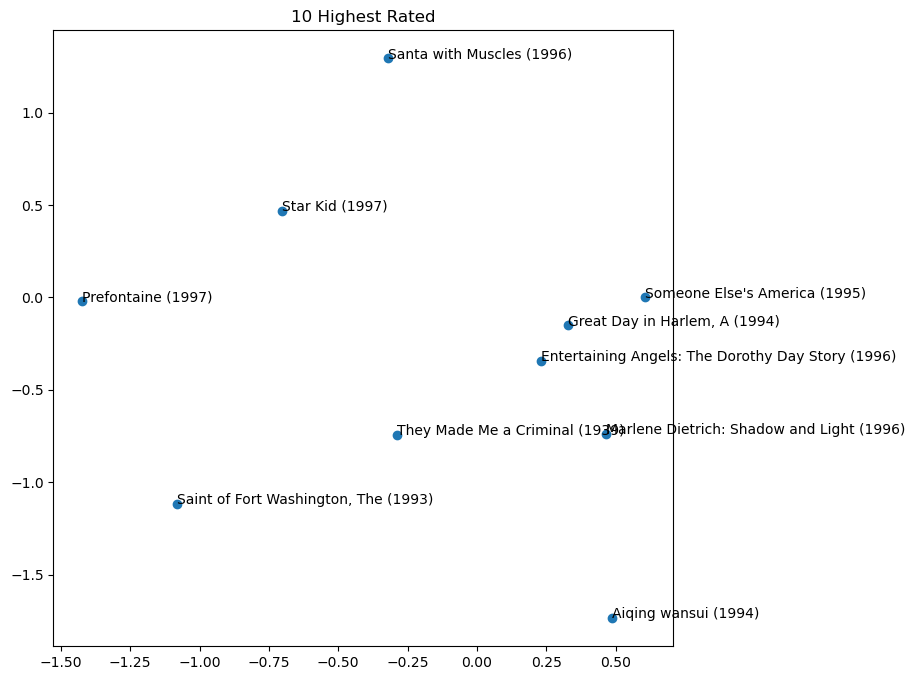

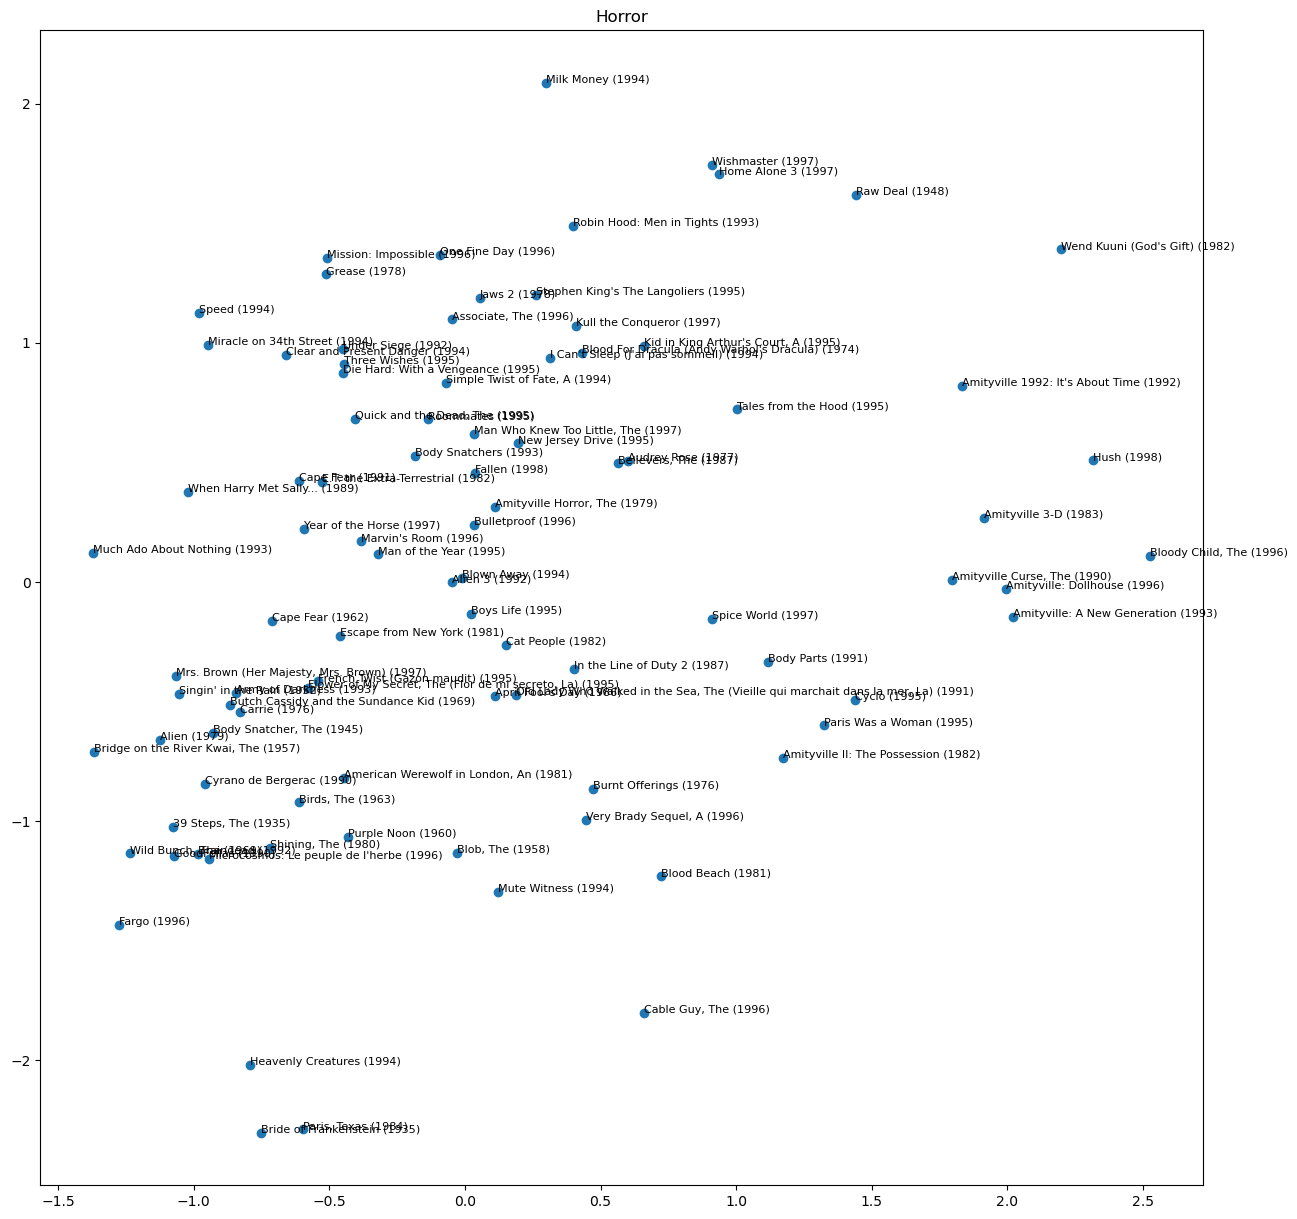

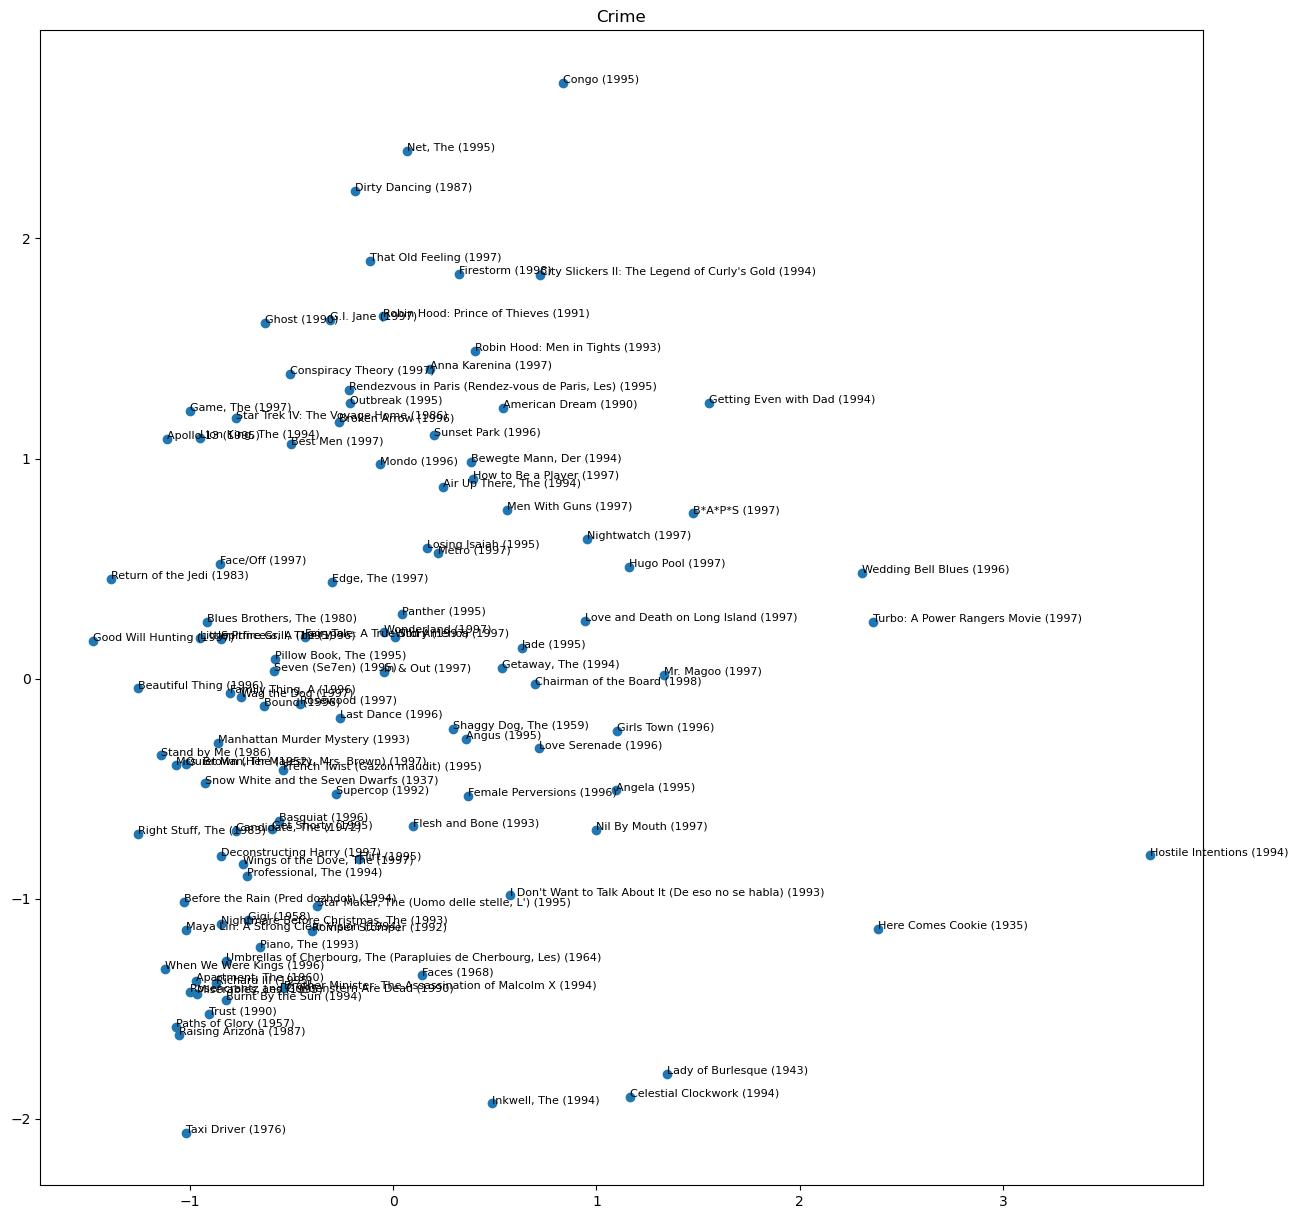

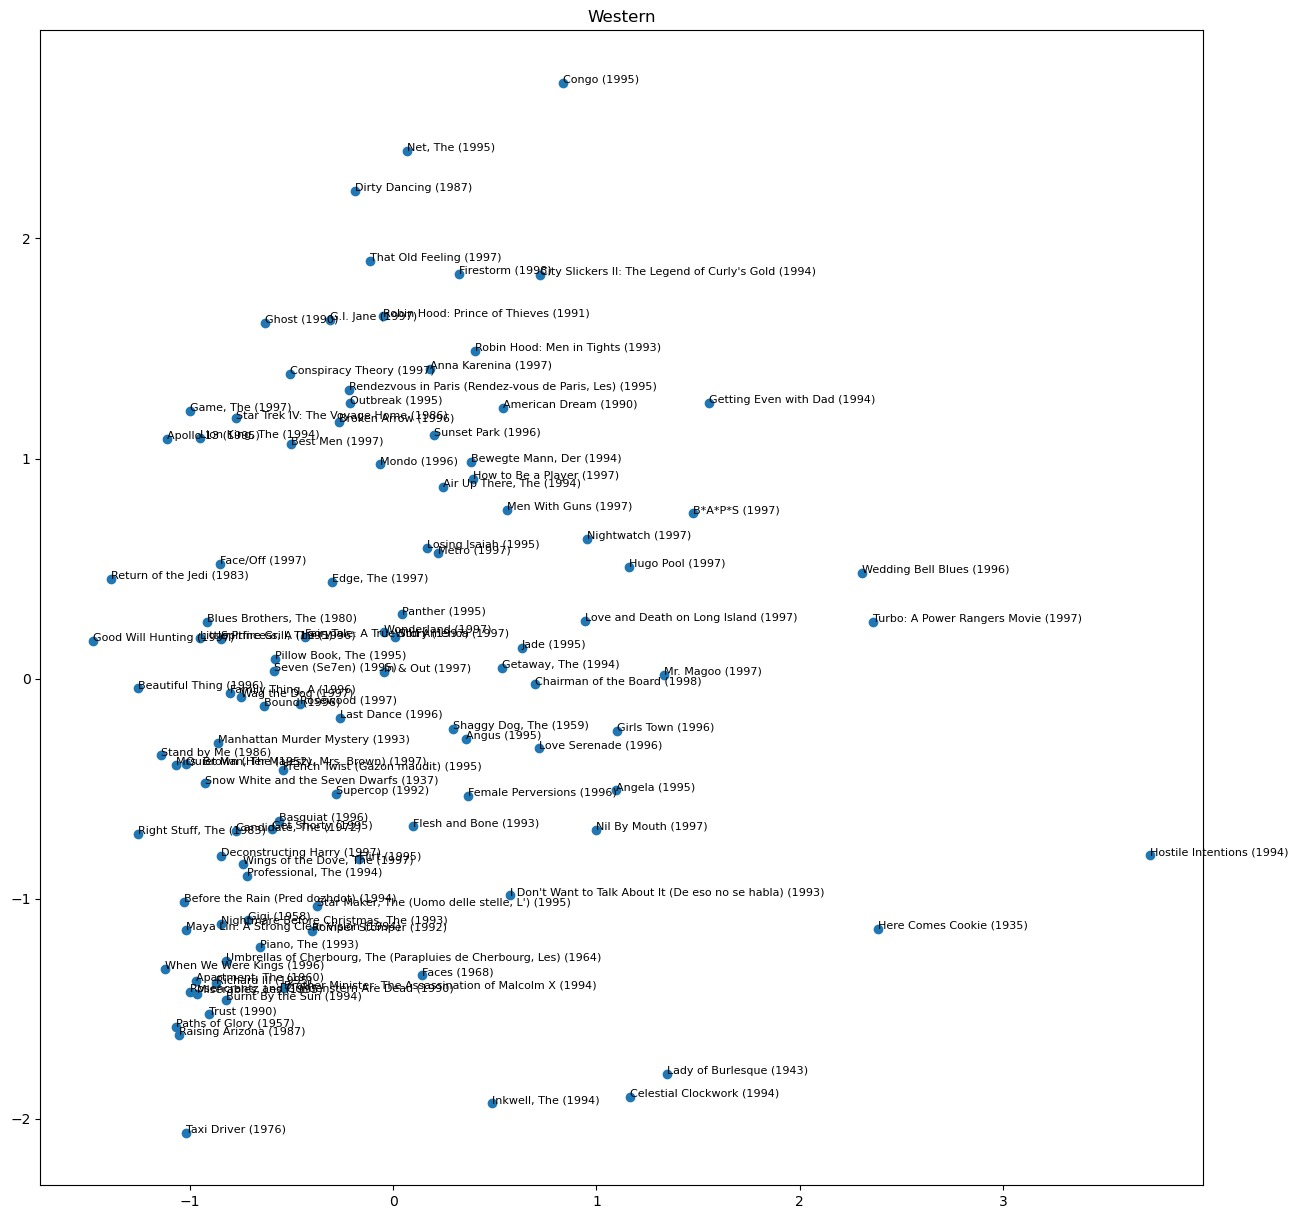

In [24]:
# random 10 movies
fig_rand = proj_plot(Vt2_biased, rand_indices, "10 Random Movies", "rand10_sp.png")

# top10 high rating
fig_top = proj_plot(Vt2_biased, most_pd.index - 1, "10 Most Rated", "pop10_sp.png")

# top10, received most ratings
fig_most = proj_plot(Vt2_biased, high_pd.index - 1, "10 Highest Rated", "most10_sp.png")

# Horror
fig_horror = proj_plot(Vt2_biased, horror_pd.index - 1, "Horror", "horror_SVD_sp.png", plot_size = (15, 15), fontsize = 8)

# Crime
fig_crime = proj_plot(Vt2_biased, crime_pd.index - 1, "Crime", "crime_SVD_sp.png", plot_size = (15, 15), fontsize = 8)

# Western
fig_crime = proj_plot(Vt2_biased, crime_pd.index - 1, "Western", "western_SVD_sp.png", plot_size = (15, 15), fontsize = 8)